# First evaluation insights for the Abilene network

This notebook is copied and adjusted from the old Abilene network. But this notebook uses the new results with the "fixed" emulator that should use the same shortest paths as the simulation (according to delay not hop count).

**Inputs:**
* Algorithms: bjointsp, greedy, random
* Network: Abilene
* Service: fw1chain, fw2chain, fw3chain
* Sources: source0-9

Abilene a standard, small network used for experiments. The figure shows the network with the node labels and IDs in black as well as link delays (in ms) in red between the nodes.

![Abilene](../docs/abilene.jpg)

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# include and import place_emu/util/eval.py
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path) 
from place_emu.util import eval


bjointsp_chain_df, bjointsp_aux_chain_df, bjointsp_vnf_df, bjointsp_aux_vnf_df = eval.prepare_eval('Abilene', 'bjointsp')
greedy_chain_df, greedy_aux_chain_df, greedy_vnf_df, greedy_aux_vnf_df = eval.prepare_eval('Abilene', 'greedy')
random_chain_df, random_aux_chain_df, random_vnf_df, random_aux_vnf_df = eval.prepare_eval('Abilene', 'random')

In [2]:
# combined dfs for easier eval
aux_vnf_df = pd.concat([bjointsp_aux_vnf_df, greedy_aux_vnf_df, random_aux_vnf_df])
vnf_df = pd.concat([bjointsp_vnf_df, greedy_vnf_df, random_vnf_df])
chain_df = pd.concat([bjointsp_chain_df, greedy_chain_df, random_chain_df])

There are 12 different pandas dataframes, four for each of the placement algorithms. 

chain_df contains the delays (RTTs) of the whole chain and vnf_df contains the inter-VNF delays. They have separate columns for the simulation and emulation RTTs and additional columns for the difference and the ratio between simulation and emulation RTT.

For easier plotting later, aux_chain_df and aux_vnf_df contain the same data as chain_df and vnf_df, respectiveley, just in a different structure: Here, there is just one column called 'rtt'. Simulation and emulation delays are stored in the same column in different rows. They are distinguished by a new column 'type' that is either 'sim' or 'emu', classifying the type of RTT.

For better intuition, see the tables below.

In [3]:
bjointsp_chain_df.head()

,network,num_nodes,num_edges,service,num_vnfs,sources,num_sources,algorithm,sim_rtt,emu_rtt,rtt_diff,rtt_ratio
0,Abilene,11,14,fw1chain,3,source0,1,bjointsp,6.0,7.1,1.1,1.183333
1,Abilene,11,14,fw1chain,3,source1,1,bjointsp,6.0,7.1,1.1,1.183333
2,Abilene,11,14,fw1chain,3,source2,1,bjointsp,8.0,9.1,1.1,1.137500
3,Abilene,11,14,fw1chain,3,source3,1,bjointsp,8.0,9.1,1.1,1.137500
4,Abilene,11,14,fw1chain,3,source4,1,bjointsp,14.0,15.1,1.1,1.078571


In [4]:
bjointsp_aux_chain_df.head()

,algorithm,network,num_nodes,num_edges,service,num_vnfs,sources,num_sources,rtt,type
0,bjointsp,Abilene,11,14,fw1chain,3,source0,1,6.0,sim
1,bjointsp,Abilene,11,14,fw1chain,3,source1,1,6.0,sim
2,bjointsp,Abilene,11,14,fw1chain,3,source2,1,8.0,sim
3,bjointsp,Abilene,11,14,fw1chain,3,source3,1,8.0,sim
4,bjointsp,Abilene,11,14,fw1chain,3,source4,1,14.0,sim


In [5]:
bjointsp_vnf_df.head()

,network,num_nodes,num_edges,service,num_vnfs,sources,num_sources,algorithm,src,dest,sim_rtt,emu_rtt,rtt_diff,rtt_ratio
0,Abilene,11,14,fw1chain,3,source0,1,bjointsp,vnf_user,vnf_fw1,2.0,2.192,0.192,1.09600
1,Abilene,11,14,fw1chain,3,source0,1,bjointsp,vnf_fw1,vnf_web,4.0,4.218,0.218,1.05450
2,Abilene,11,14,fw1chain,3,source1,1,bjointsp,vnf_user,vnf_fw1,2.0,2.188,0.188,1.09400
3,Abilene,11,14,fw1chain,3,source1,1,bjointsp,vnf_fw1,vnf_web,4.0,4.213,0.213,1.05325
4,Abilene,11,14,fw1chain,3,source2,1,bjointsp,vnf_user,vnf_fw1,2.0,2.199,0.199,1.09950


## Inter-VNF RTT
Let's do the same for inter-VNF delays/RTTs. Now, we're looking at two VNFs in isolation, i.e., independent of the rest of the chain. Thus, we're not considering chain length.

Text(0.5,1,'Inter-VNF RTT')

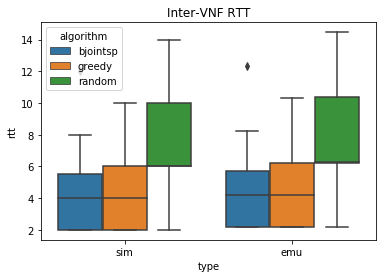

In [6]:
sns.boxplot(x='type', y='rtt', hue='algorithm', data=aux_vnf_df).set_title('Inter-VNF RTT')

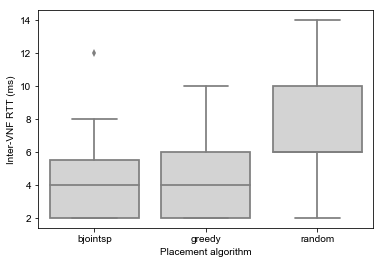

In [7]:
# tuned figure for paper: focus on sim_rtt (emu_rtt similar and checked later)
fig, ax = plt.subplots()
sns.set(font_scale=1.5)
sns.boxplot(x='algorithm', y='sim_rtt', data=vnf_df, color='lightgrey', ax=ax)
#ax.set_title('Sim. inter-VNF RTT')
ax.set_xlabel('Placement algorithm')
ax.set_ylabel('Inter-VNF RTT (ms)')
ax.set_facecolor('white')
fig.savefig('plots/abilene_sim_vnf_rtt.pdf', bbox_inches='tight')

As expected, random placement also leads to much higher inter-VNF delays than bjointsp and greedy. Greedy is similar to bjointsp but may lead to some higher inter-VNF delays.
The difference between simulation and emulation delays seems to be negligible when considering inter-VNF RTTs. Let's look into that further.

### Inter-VNF RTT difference

Absolute difference between emulated and simulated inter-VNF RTT: emu_rtt - sim_rtt

Text(0.5,1,'Inter-VNF RTT difference')

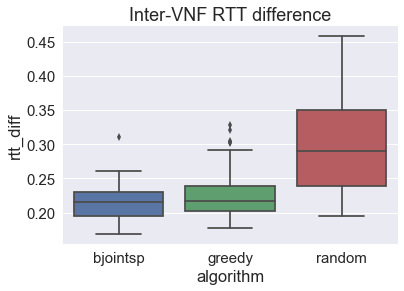

In [8]:
sns.boxplot(x='algorithm', y='rtt_diff', data=vnf_df).set_title('Inter-VNF RTT difference')

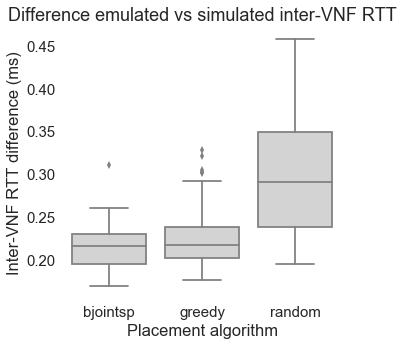

In [9]:
# tuned figure for paper
fig, ax = plt.subplots(figsize=(5,5))
sns.set(font_scale=1.5)
sns.boxplot(x='algorithm', y='rtt_diff', data=vnf_df, ax=ax, color='lightgrey')
ax.set_title('Difference emulated vs simulated inter-VNF RTT')
ax.set_xlabel('Placement algorithm')
ax.set_ylabel('Inter-VNF RTT difference (ms)')
ax.set_facecolor('white')
fig.savefig('plots/abilene_vnf_rtt_diff.pdf', bbox_inches='tight')

The absolute difference between simulated and emulated inter-VNF RTTs is rather small. 

For bjointsp and greedy, it is generally smaller than for random placement. Also the spread is smaller. This is probably due to the longer paths in random placement, which allow for more deviation between simulation and emulation.

Text(0.5,1,'Random inter-VNF RTT difference')

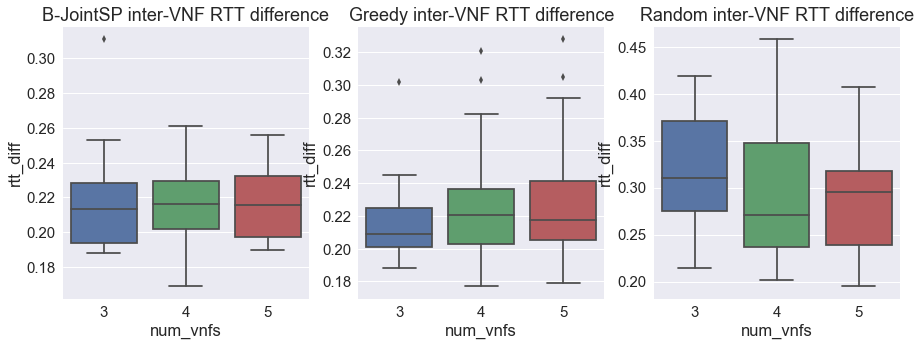

In [10]:
# plot RTT difference for different chain lengths
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(x='num_vnfs', y='rtt_diff', data=bjointsp_vnf_df, ax=ax1).set_title('B-JointSP inter-VNF RTT difference')
sns.boxplot(x='num_vnfs', y='rtt_diff', data=greedy_vnf_df, ax=ax2).set_title('Greedy inter-VNF RTT difference')
sns.boxplot(x='num_vnfs', y='rtt_diff', data=random_vnf_df, ax=ax3).set_title('Random inter-VNF RTT difference')

As expected, the chain length does not affect the inter-VNF RTT.

Text(0.5,1,'Random placement')

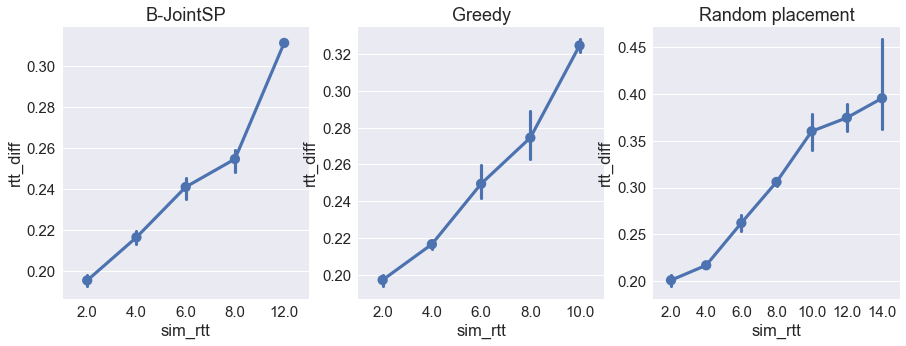

In [11]:
# plot RTT difference as a variable of the node distance = link delay = sim delay/RTT
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
sns.pointplot(x='sim_rtt', y='rtt_diff', data=bjointsp_vnf_df, ax=ax1).set_title('B-JointSP')
sns.pointplot(x='sim_rtt', y='rtt_diff', data=greedy_vnf_df, ax=ax2).set_title('Greedy')
sns.pointplot(x='sim_rtt', y='rtt_diff', data=random_vnf_df, ax=ax3).set_title('Random placement')

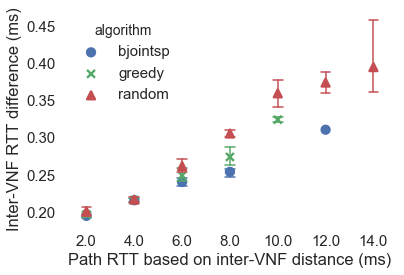

In [12]:
# tuned figure for paper
fig, ax = plt.subplots()
sns.set(font_scale=1.5)
#black_palette = sns.color_palette(['black', 'black', 'black'])
sns.pointplot(x='sim_rtt', y='rtt_diff', data=vnf_df, ax=ax,
              hue='algorithm', join=False, markers=['o', 'x', '^'], errwidth=1.5, capsize=0.2)
#ax.set_title('Difference emulated vs simulated inter-VNF RTT')
ax.set_xlabel('Path RTT based on inter-VNF distance (ms)')
ax.set_ylabel('Inter-VNF RTT difference (ms)')
ax.set_facecolor('white')
fig.savefig('plots/abilene_vnf_rtt_diff_sim_rtt.pdf', bbox_inches='tight')

The difference of emulated and simulated inter-VNF RTTs increases with increasing simulated inter-VNF RTT. The simulated inter-VNF RTT directly reflects the link delay and thus distance between two connected VNFs.

Hence, for two very close VNFs, the simulated and emulated delays are almost identical, but for VNFs that are placed farther away (higher sim_rtt), the emulated delay can be significantly larger than the simulated delay.


### Inter-VNF RTT ratio

Relative ratio of emulated vs. simulated inter-VNF RTT: emu_rtt / sim_rtt

Set to infinity if sim_rtt = 0. Doesn't happen here; see below.

In [13]:
# set infinite ratios to NaN, so they are ignored when plotting
print('Entries with inifinite ratio: {}'.format(vnf_df['rtt_ratio'].loc[vnf_df['rtt_ratio'] == np.inf].count()))
vnf_df = vnf_df.replace(np.inf, np.nan)

Entries with inifinite ratio: 0


Text(0.5,1,'Inter-VNF RTT ratio')

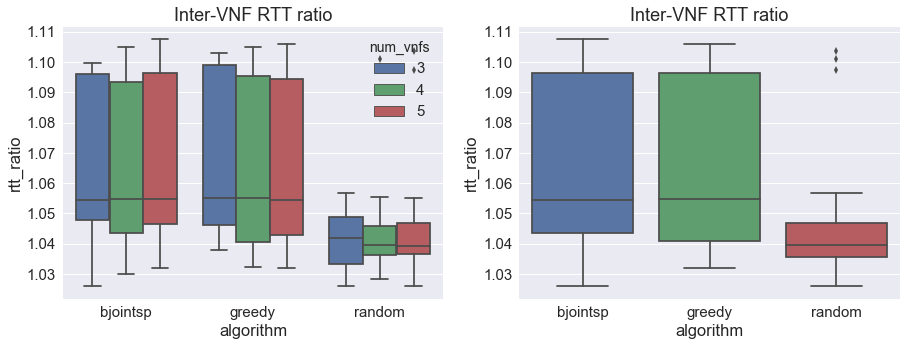

In [14]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(x='algorithm', y='rtt_ratio', hue='num_vnfs', data=vnf_df, ax=ax1).set_title('Inter-VNF RTT ratio')
# splitting the plot up for different chain lengths doesn't help so much
sns.boxplot(x='algorithm', y='rtt_ratio', data=vnf_df, ax=ax2).set_title('Inter-VNF RTT ratio')

Similar to the chain RTT ratio, the inter-VNF RTT ratio is pretty much constant with increasing chain length and very close to 1.

While very close to 1 for both algorithms, bjoint sp has slightly higher ratios with significantly higher spread than random placement. This is likely due to the overall longer paths between VNFs in random placment, which lead to a lower relative ratio between emulated and simulated delay. Here, the relative impact of VNF processing delays (only in emulation, not simulation) is smaller.

## Chain RTT

Let's continue the evaluation by analyzing the RTT of the whole chain, comparing the different placement algorithms.

Text(0.5,1,'Emulation chain RTT')

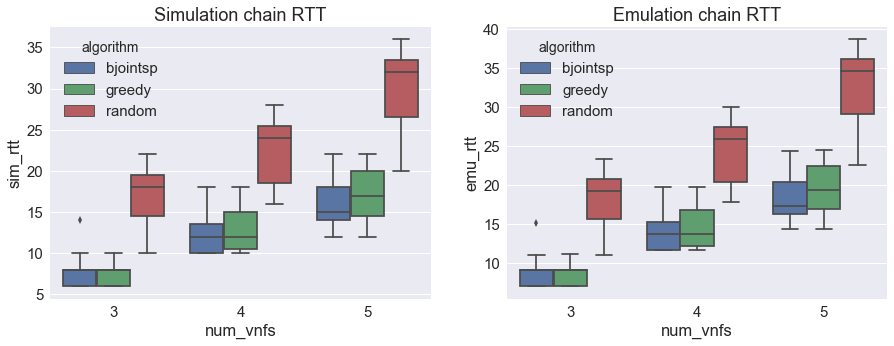

In [15]:
# comparison of bjointsp and random placement
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(x='num_vnfs', y='sim_rtt', hue='algorithm', data=chain_df, ax=ax1).set_title('Simulation chain RTT')
sns.boxplot(x='num_vnfs', y='emu_rtt', hue='algorithm', data=chain_df, ax=ax2).set_title('Emulation chain RTT')

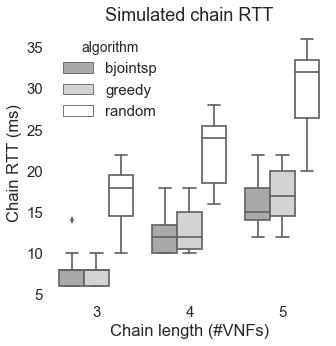

In [16]:
# tuned figure for paper
fig, ax = plt.subplots(figsize=(5,5))
sns.set(font_scale=1.5)
grayscale = sns.color_palette(['darkgray', 'lightgray', 'white'])
sns.boxplot(x='num_vnfs', y='sim_rtt', hue='algorithm', data=chain_df, ax=ax, palette=grayscale)
ax.set_title('Simulated chain RTT')
ax.set_xlabel('Chain length (#VNFs)')
ax.set_ylabel('Chain RTT (ms)')
ax.set_facecolor('white')
fig.savefig('plots/abilene_chain_rtt.pdf', bbox_inches='tight')

Clearly, random placement leads to much higher simulation and emulation delays than bjointsp. Greedy leads to quite similar (or slightly higher delays). For all algorithms, the delays increase notably with increasing chain length (num_vnfs).

Compared to the large Airtel network, the difference between bjointsp and random placement is not as big in the small Abilene network.

Text(0.5,1,'Random chain RTT')

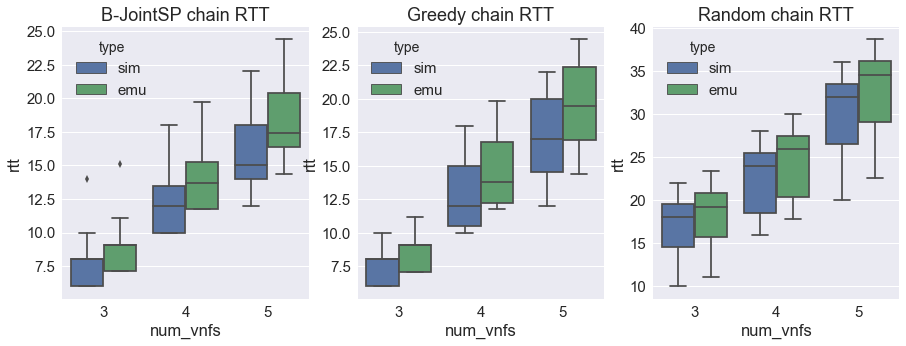

In [17]:
# comparison of simulation and emulation delays
# this is what aux_chain_df is for
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(x='num_vnfs', y='rtt', hue='type', data=bjointsp_aux_chain_df, ax=ax1).set_title('B-JointSP chain RTT')
sns.boxplot(x='num_vnfs', y='rtt', hue='type', data=greedy_aux_chain_df, ax=ax2).set_title('Greedy chain RTT')
sns.boxplot(x='num_vnfs', y='rtt', hue='type', data=random_aux_chain_df, ax=ax3).set_title('Random chain RTT')

Compared to the Airtel network, the difference between simulation and emulation appears much larger in the Abilene network. In Abilene, link delays are shorter and VNF processing delays (not considered in simulation) have a larger relative impact.


### Chain RTT difference

Absolute difference between emulated and simulated chain RTT: emu_rtt - sim_rtt

Text(0.5,1,'Random chain RTT difference')

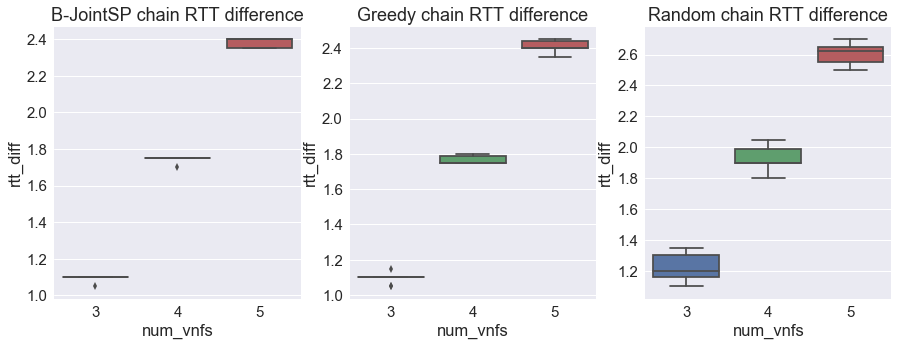

In [18]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(x='num_vnfs', y='rtt_diff', data=bjointsp_chain_df, ax=ax1).set_title('B-JointSP chain RTT difference')
sns.boxplot(x='num_vnfs', y='rtt_diff', data=greedy_chain_df, ax=ax2).set_title('Greedy chain RTT difference')
sns.boxplot(x='num_vnfs', y='rtt_diff', data=random_chain_df, ax=ax3).set_title('Random chain RTT difference')

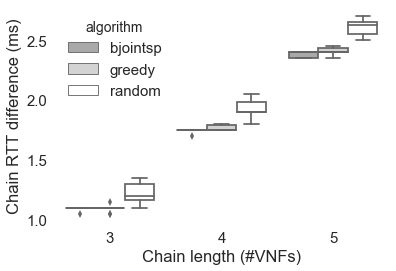

In [19]:
# tuned figure for paper
fig, ax = plt.subplots()
sns.set(font_scale=1.5)
grayscale = sns.color_palette(['darkgray', 'lightgray', 'white'])
sns.boxplot(x='num_vnfs', y='rtt_diff', hue='algorithm', data=chain_df, ax=ax, palette=grayscale)
#ax.set_title('Difference emulated vs simulated chain RTT')
ax.set_xlabel('Chain length (#VNFs)')
ax.set_ylabel('Chain RTT difference (ms)')
ax.set_facecolor('white')
fig.savefig('plots/abilene_chain_rtt_diff.pdf', bbox_inches='tight')

Looking at the difference in RTT, the emulation delay is clearly higher than the simulation delay. And the difference between the two increases with increasing chain length. There is surprisingly little deviation/spread in rtt_diff for each chain length, meaning that any difference can be well explained through chain length.

For random placement, the absolute difference between simulated and emulated chain RTTs is a little higher (longer paths).


### Chain RTT ratio

Relative ratio of emulated vs. simulated chain RTT: emu_rtt / sim_rtt

Text(0.5,1,'Chain RTT ratio')

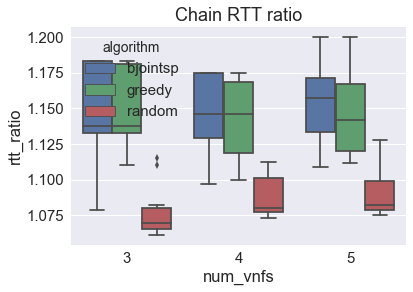

In [20]:
sns.boxplot(x='num_vnfs', y='rtt_ratio', hue='algorithm', data=chain_df).set_title('Chain RTT ratio')

**B-JointSP**: While the absolute difference between emulated and simulated chain RTT clearly increases for increasing chain length, the relative ratio of the two stays fairly constant at slightly above 1.

**Greedy**: Similar to B-JointSP but rather smaller ratio. The slightly longer paths for 5 VNFs lead to larger sim_rtt and emu_rtt and a smaller ratio.

**Random**: While the absolute RTT difference is higher, random placement actually has a lower relative ratio RTT ratio compared to the other algorithms. Again, likely due to lower relative impact of VNF processing.

# Conclusion

* The emulation fix removes any weird outliers. Now the results make sense.
* Emulation RTTs are generally a little higher than simulation due to VNF processing and "real-world" dirt effects
* This difference depends on how far two VNFs are placed away from each other. The farther away, the stronger the deviation between simulation and emulation.
* Looking at whole chain RTTs, this effect adds up and is stronger for longer chains.
* Comparing different algorithms regarding RTT, bjointsp and greedy are rather similar, bjointsp a little better. Random placement is significantly worse.